# Automated Feature Selection


* 6G7V0017 Advanced Machine Learning 24/25
* Luciano Gerber
* Semester 2 Week 5

## Why feature selection?

- Simplicity (fewer features, higher comprehensibility?)
- Prevent overfitting
- Prevent multicollinearity
- Uninformative features might hurt some models
- Train/predict performance

## Main Strategies

* https://scikit-learn.org/stable/modules/feature_selection.html

* unsupervised (e.g., removing features with low variance)

* supervised, univariate, correlation with target (e.g., select $k$ best) - metric is parameterisable

* multivariate
    - RFE (Recursive Feature Elimination)
    - From Model (e.g., feature importance based)
    - SFS (Sequential Feature Selection)


## Import Packages and Set Up Environment

In [ ]:
# !pip install -q shap

In [ ]:
import sklearn
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.metrics import mean_absolute_error

import shap
shap.initjs()

In [ ]:
from sklearn.datasets import make_regression

## Case Study: Synthetic Dataset

### Making the Regression Dataset

The technicalities here are not the today's topic. The important message is that we ask `sklearn` to create a synthetic dataset with 200 samples, 10 features, 7 of which being informative, for a quantitative target (regression).

In [ ]:
X, y = make_regression(
    n_samples=200,
    n_features=10,
    n_informative=7,
    noise=0.2,
    effective_rank=4,
    random_state=42
)

In [ ]:
X = pd.DataFrame(X).rename(columns=lambda x: 'x' + str(x))
X.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,-0.056711,-0.040479,-0.001992,0.048749,-0.003496,-0.003888,-0.018376,-0.057141,-0.066291,0.020132
1,0.015563,-0.132476,-0.020419,0.066564,0.044311,0.010720,0.127621,0.102073,0.067242,-0.060032
2,0.023726,-0.001814,0.010952,0.071639,0.013104,0.076464,0.060048,0.040878,0.104568,-0.030093
3,-0.002274,0.097474,0.001153,-0.030261,0.030729,-0.099788,0.004121,-0.013760,-0.041493,-0.031670
4,-0.003701,-0.031351,-0.045230,0.084394,0.060211,-0.033222,0.048933,-0.056874,-0.114203,0.004870


In [ ]:
y = pd.Series(y).rename('target')
y.head()

,target
0,-9.403197
1,10.511787
2,15.548426
3,3.659229
4,0.809514


In [ ]:
data = pd.concat([X,y], axis='columns')
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,target
0,-0.056711,-0.040479,-0.001992,0.048749,-0.003496,-0.003888,-0.018376,-0.057141,-0.066291,0.020132,-9.403197
1,0.015563,-0.132476,-0.020419,0.066564,0.044311,0.010720,0.127621,0.102073,0.067242,-0.060032,10.511787
2,0.023726,-0.001814,0.010952,0.071639,0.013104,0.076464,0.060048,0.040878,0.104568,-0.030093,15.548426
3,-0.002274,0.097474,0.001153,-0.030261,0.030729,-0.099788,0.004121,-0.013760,-0.041493,-0.031670,3.659229
4,-0.003701,-0.031351,-0.045230,0.084394,0.060211,-0.033222,0.048933,-0.056874,-0.114203,0.004870,0.809514


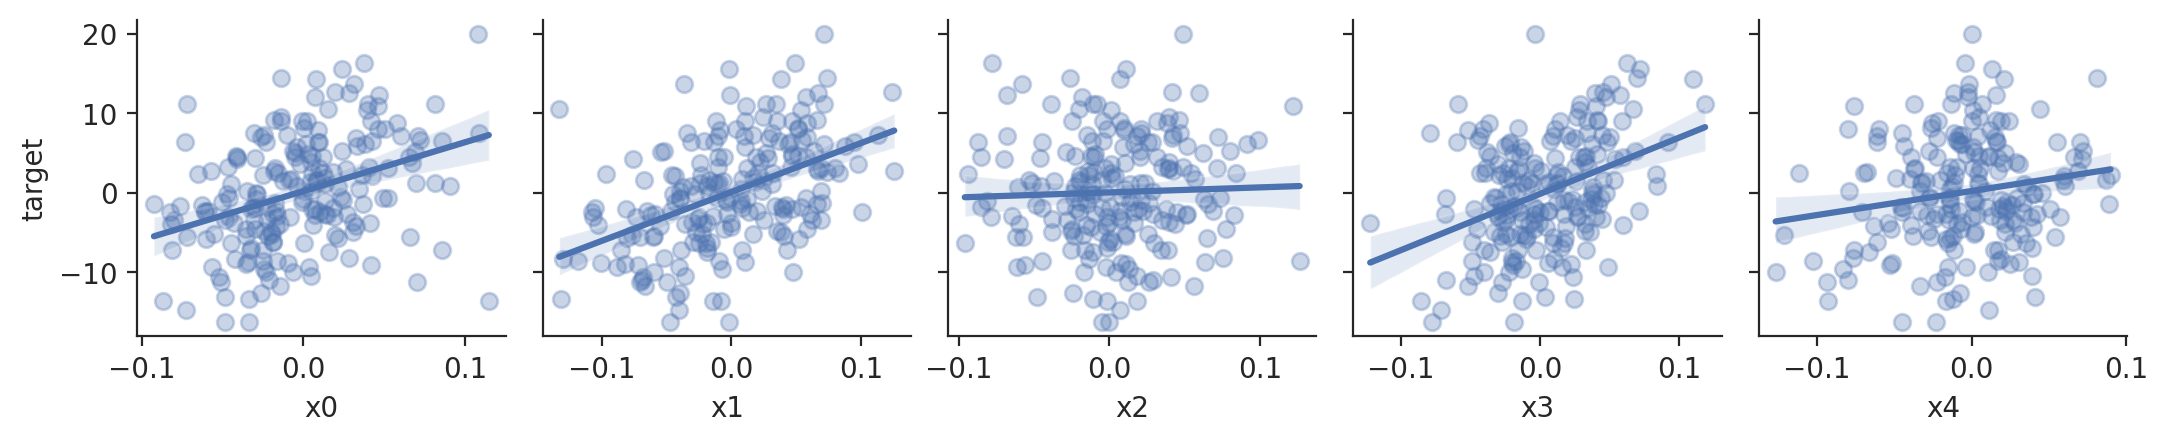

In [ ]:
sns.pairplot(
    data=data, x_vars=['x0','x1','x2','x3','x4'], y_vars='target',
    kind='reg', plot_kws=dict(scatter_kws=(dict(alpha=0.3))),
    height=2.2
);

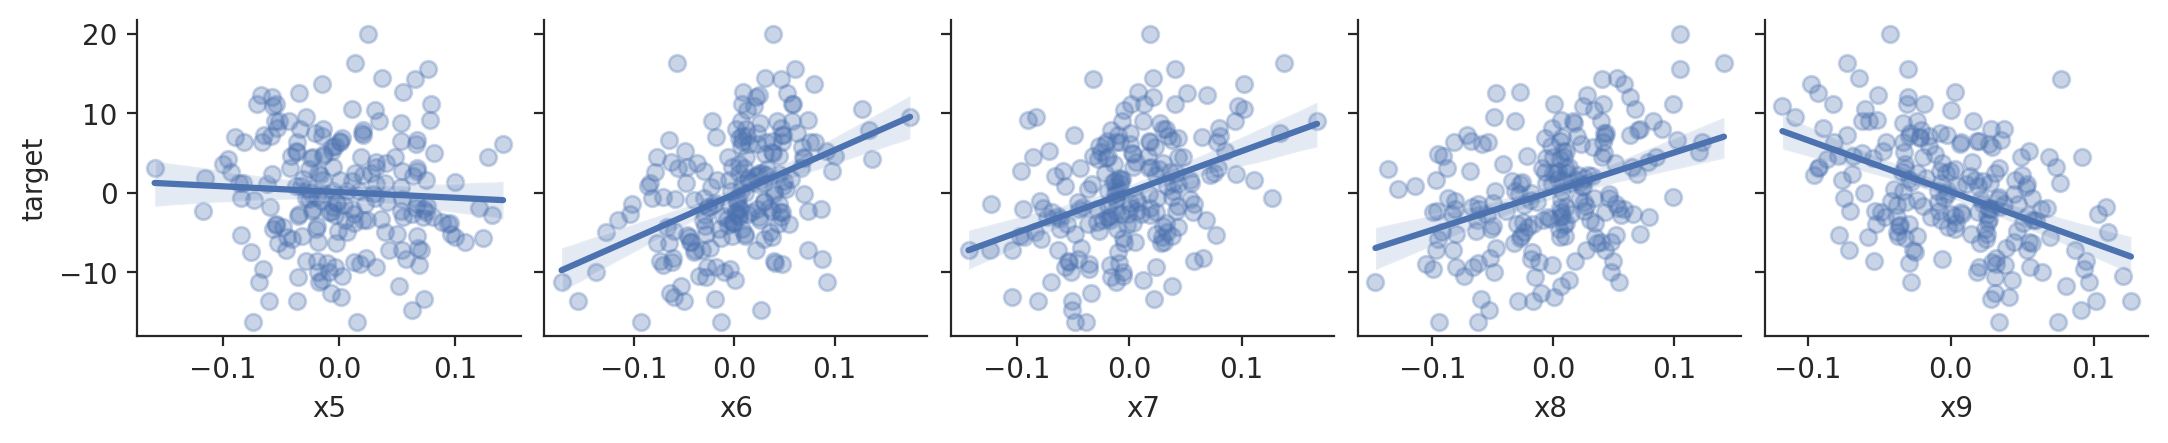

In [ ]:
sns.pairplot(
    data=data, x_vars=['x5','x6','x7','x8','x9'], y_vars='target',
    height=2.2, kind='reg', plot_kws=dict(scatter_kws=(dict(alpha=0.3)))
);

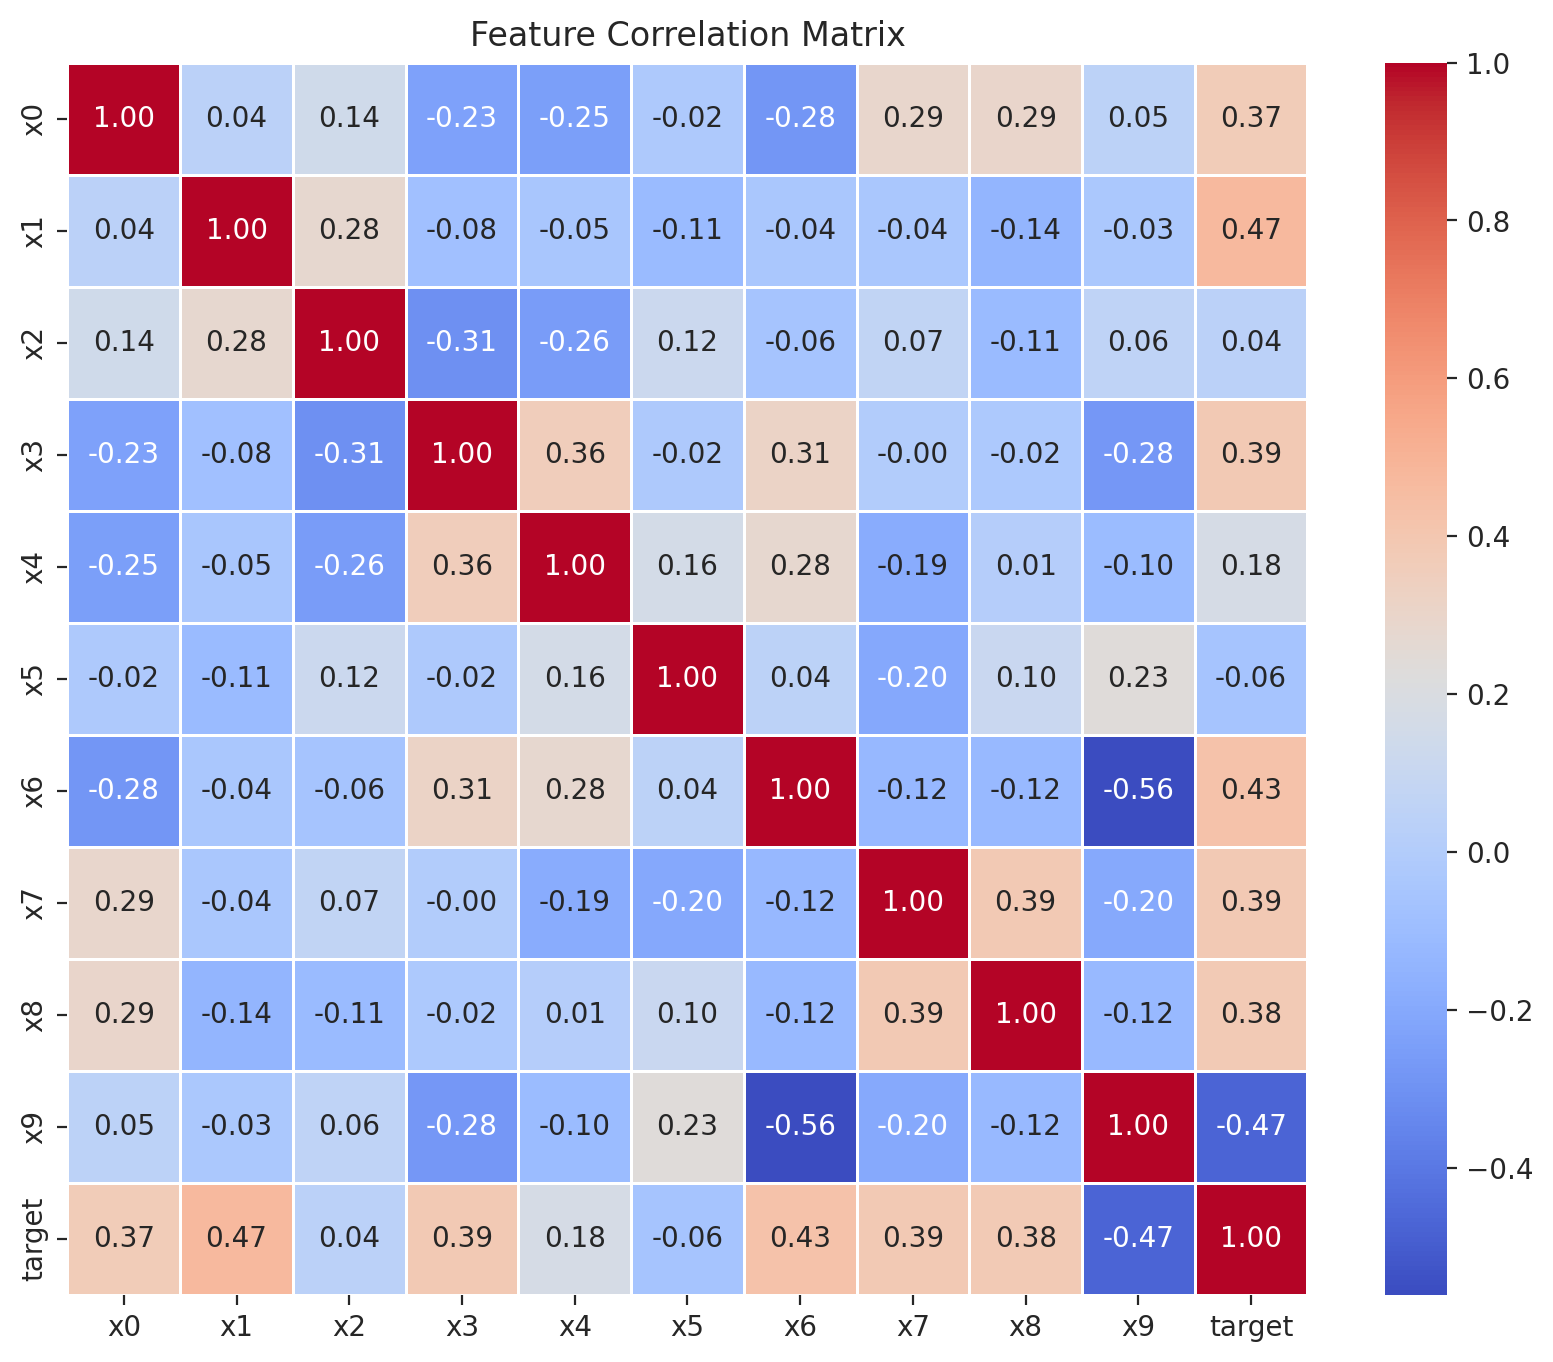

In [ ]:
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
ax.set_title("Feature Correlation Matrix");

* **Which features would you exclude?**

### Automated Feature Selection (AFS): Univariate

* Supervised, univariate, **relationship with target**
    - We've done it before manually and with the support of EDA
    - Bear in mind that it is univariate... if a feature is useful only for interactions, it won't be picked up
    - Most common case is `SelectKBest` with `f_regression` or `f_classif`

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
selector = SelectKBest(f_regression, k=4).fit(X, y)
X_sel = selector.transform(X)

In [ ]:
X_sel.head()

,x1,x3,x6,x9
0,-0.040479,0.048749,-0.018376,0.020132
1,-0.132476,0.066564,0.127621,-0.060032
2,-0.001814,0.071639,0.060048,-0.030093
3,0.097474,-0.030261,0.004121,-0.031670
4,-0.031351,0.084394,0.048933,0.004870


In [ ]:
selector.get_feature_names_out()

array(['x1', 'x3', 'x6', 'x9'], dtype=object)

In [ ]:
model = LinearRegression().fit(X_sel, y)
scores = cross_val_score(model, X_sel, y)
scores.mean(), scores.std()

(0.49968543254152253, 0.07497769377633372)

In [ ]:
model = LinearRegression().fit(X, y)
scores = cross_val_score(model, X, y)
scores.mean(), scores.std()

(0.9990205733326365, 0.0003333120332543318)

In [ ]:
selector.scores_

array([30.85284912, 56.23226928,  0.27976057, 35.49135069,  6.27764122,
        0.64049622, 44.00826281, 35.24505752, 34.30049219, 56.71695846])

### Recursive Feature Elimination (RFE)

- mindset: start with all, build the model, look at **feature importance** (e.g., `coef_`), remove the least important, repeat.
- you will need to provide a $k$.

We will go straight to `RFECV`, where the best $k$ is obtained for you based on cross-validation scores.

In [ ]:
from sklearn.feature_selection import RFECV

In [ ]:
model = LinearRegression()
rfe_selector = RFECV(model, step=1, cv=5)

In [ ]:
rfe_selector.fit(X, y)

RFECV(cv=5, estimator=LinearRegression())

In [ ]:
X_sel = rfe_selector.transform(X)
X_sel.head()

,x0,x1,x3,x4,x6,x7,x8
0,-0.056711,-0.040479,0.048749,-0.003496,-0.018376,-0.057141,-0.066291
1,0.015563,-0.132476,0.066564,0.044311,0.127621,0.102073,0.067242
2,0.023726,-0.001814,0.071639,0.013104,0.060048,0.040878,0.104568
3,-0.002274,0.097474,-0.030261,0.030729,0.004121,-0.013760,-0.041493
4,-0.003701,-0.031351,0.084394,0.060211,0.048933,-0.056874,-0.114203


In [ ]:
rfe_selector.get_feature_names_out()

array(['x0', 'x1', 'x3', 'x4', 'x6', 'x7', 'x8'], dtype=object)

In [ ]:
n_scores = len(rfe_selector.cv_results_["mean_test_score"])
n_scores

10

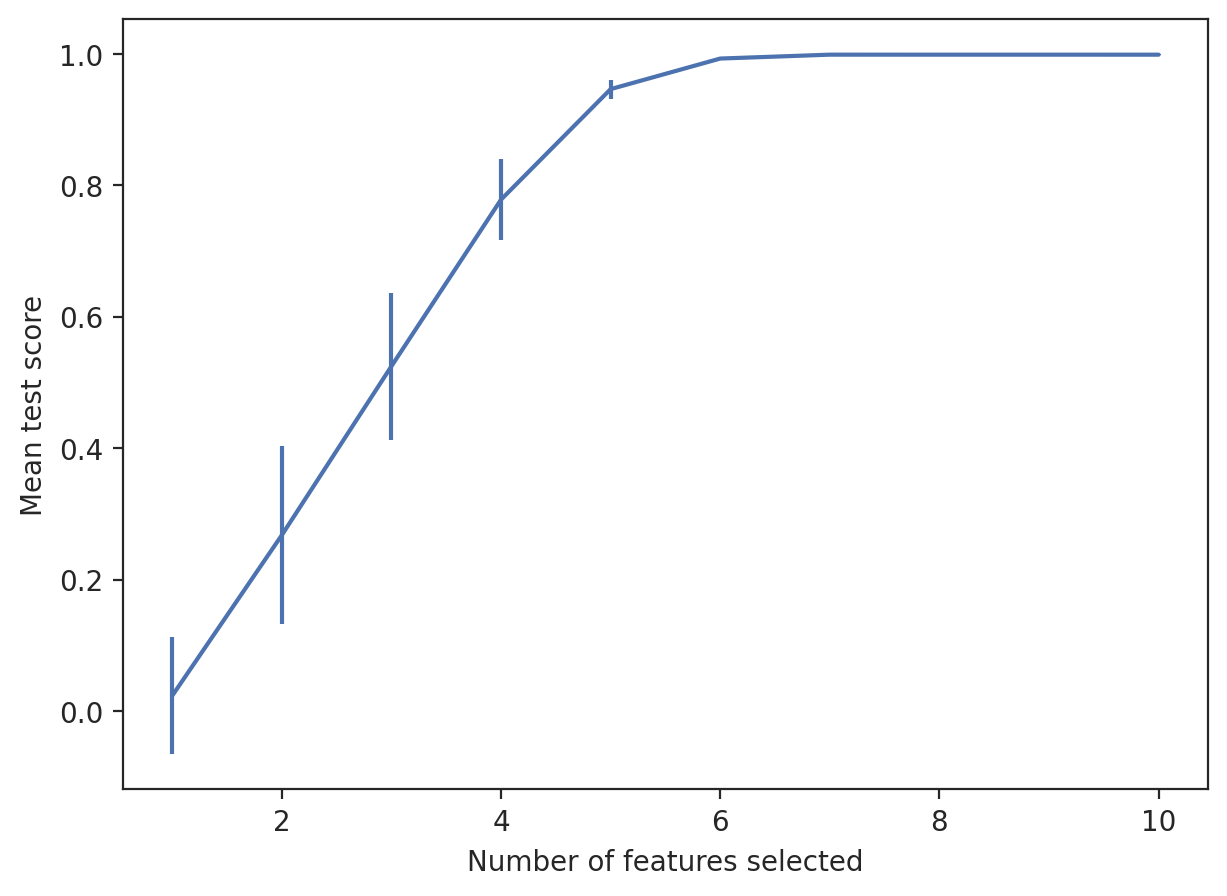

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    rfe_selector.cv_results_["mean_test_score"],
    yerr=rfe_selector.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

In [ ]:

rfe_selector.ranking_

In [ ]:
np.argsort(rfe_selector.ranking_)

In [ ]:
np.flip(np.argsort(rfe_selector.ranking_))

In [ ]:
# Please do not worry if you don't fully understand the code!
# all that I am trying to get is a ranking of features acccording to the
# RFE selector; below I see more or less the order in which the features
# are eliminated
rfe_selector.feature_names_in_[ np.flip(np.argsort(rfe_selector.ranking_)) ]

In [ ]:
rfe_selector.support_

### Sequential Feature Selection (SFS) (Forward/Backward)

- Greedy search
- Forward-SFS: "start with zero features and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached"
- difference from RFE: **model performance**

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
sfs_forward = SequentialFeatureSelector(
    LinearRegression(), n_features_to_select='auto', direction="forward", tol=0.05
).fit(X, y)

from https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html:

    n_features_to_select“auto”, int or float, default=”auto”
    If "auto", the behaviour depends on the tol parameter:
    if tol is not None, then features are selected while the score change does not exceed tol.
    otherwise, half of the features are selected.
    If integer, the parameter is the absolute number of features to select. If float between 0 and 1, it is the fraction of features to select.

In [ ]:
sfs_forward.get_feature_names_out()

array(['x0', 'x1', 'x3', 'x6', 'x8', 'x9'], dtype=object)

In [ ]:
X_sel = sfs_forward.transform(X)

In [ ]:
model = LinearRegression().fit(X_sel, y)
scores = cross_val_score(model, X_sel, y)
scores.mean(), scores.std()

(0.9481891535549394, 0.01611886969432844)

## Case Study: Bike Rides Pipeline

## The Bike Rides Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/gerberl/6G7V0017-2324/main/datasets/bike.csv'
bike = pd.read_csv(url)
bike.head()

In [ ]:
# we decided last week that we are happy keeping most existing features as predictors,
# but we'll take out *year*, as it doesn't seem to add much when we already have
# `days_since_2011`.

In [ ]:
y = bike['cnt']
X = bike.drop(['cnt', 'yr'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=0
)

In [ ]:
X_train.head(1)

### Pre-Processing

We are dealing with numeric features in the default, simplistic way - median for missing values - and scaling.

In [ ]:
numeric_features = X_train.select_dtypes(exclude='object').columns.tolist()
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
    ]
)
print(numeric_features)
numeric_transformer

This is what the data flowing in the pipeline (for numeric features) would look like.

In [ ]:
numeric_transformer.fit_transform(X_train[numeric_features]).head()

For categorical data, a straight-forward missing value imputation and one-hot encoding.

In [ ]:
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')),
        # ("te", TargetEncoder(target_type='continuous')),
    ]
)

And this is what the data would look like...

In [ ]:
categorical_transformer.fit_transform(X_train[categorical_features]).head()
# categorical_transformer.fit_transform(X_train[categorical_features], y_train).head()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

### Model Fitting: with and without FS

#### Without FS

In [ ]:
regr_noFS = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regr", LinearRegression())
    ]
)

In [ ]:
regr_noFS.fit(X_train, y_train)

In [ ]:
regr_noFS.score(X_test, y_test), regr_noFS.score(X_train, y_train)

In [ ]:
mean_absolute_error(y_test, regr_noFS.predict(X_test)), mean_absolute_error(y_train, regr_noFS.predict(X_train))

In [ ]:
eval_results = cross_validate(
    regr_noFS, X_train, y_train, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
(
    (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
    -eval_results['train_score'].mean(), eval_results['train_score'].std())
)

In [ ]:
regr_noFS['preprocessor'].get_feature_names_out()

In [ ]:
len(regr_noFS['preprocessor'].get_feature_names_out())

#### With Best-k

In [ ]:
regr_bestk = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("featsel", SelectKBest(f_regression, k=10)),
        ("regr", LinearRegression())
    ]
)

In [ ]:
regr_bestk.fit(X_train, y_train)

In [ ]:
regr_bestk['featsel'].get_feature_names_out()

In [ ]:
len(regr_bestk['featsel'].get_feature_names_out())

In [ ]:
regr_bestk['featsel'].transform(
    regr_bestk['preprocessor'].transform(X_train)
).head()

In [ ]:
regr_bestk.score(X_test, y_test)

In [ ]:
mean_absolute_error(y_test, regr_bestk.predict(X_test))

In [ ]:
eval_results = cross_validate(
    regr_bestk, X_train, y_train, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
(
    (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
    -eval_results['train_score'].mean(), eval_results['train_score'].std())
)

#### With RFECV

In [ ]:
regr_rfe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("featsel", RFECV(model, step=1, cv=5)),
        ("regr", LinearRegression())
    ]
)

In [ ]:
regr_rfe.fit(X_train, y_train)

In [ ]:
regr_rfe['featsel'].get_feature_names_out()

In [ ]:
len(regr_rfe['featsel'].get_feature_names_out())

In [ ]:
regr_rfe['featsel'].transform(
    regr_rfe['preprocessor'].transform(X_train)
).head()

In [ ]:
regr_rfe.score(X_test, y_test), regr_rfe.score(X_train, y_train)

In [ ]:
mean_absolute_error(y_test, regr_rfe.predict(X_test)), mean_absolute_error(y_train, regr_rfe.predict(X_train))

In [ ]:
eval_results = cross_validate(
    regr_rfe, X_train, y_train, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
(
    (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
    -eval_results['train_score'].mean(), eval_results['train_score'].std())
)